In [44]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow

In [45]:
img_size = 300
vgg = tf.keras.applications.VGG19(include_top=False,input_shape=(img_size,img_size,3), weights="imagenet")
vgg.trainable = False

In [46]:
def compute_content_loss(content_layer_outputs, generated_layer_outputs):
    a_C = content_layer_outputs[-1]
    a_G = generated_layer_outputs[-1]
    _,n_H,n_W,n_C = a_C.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C ,shape = [1,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,shape = [1,n_H*n_W,n_C])

    content_loss = (1.0/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))
    return content_loss

In [47]:
def gram_matrix(layer):
    return tf.matmul(layer, tf.transpose(layer))

In [48]:
def compute_style_loss(style_layer, generated_layer):
    _,n_H,n_W,n_C = style_layer.get_shape().as_list()
    a_S_unrolled = tf.transpose(tf.reshape(style_layer,shape = [n_H*n_W,n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(generated_layer,shape = [n_H*n_W,n_C]))
    style_loss = (1.0/(4*(n_C**2)*(n_H*n_W)**2))*(tf.reduce_sum(tf.square(tf.subtract(gram_matrix(a_S_unrolled),gram_matrix(a_G_unrolled)))))
    return style_loss

In [49]:
style_layers = [
    ('block1_conv1',0.2),
    ('block2_conv1',0.2),
    ('block3_conv1',0.2),
    ('block4_conv1',0.2),
    ('block5_conv1',0.2)
]
content_layer = [('block5_conv4',1)]

In [50]:
def overall_style_loss(style_layer_outputs,generated_layer_outputs):
    a_S = style_layer_outputs[:-1]
    a_G = generated_layer_outputs[:-1]
    loss = 0
    for i, layer in zip(range(len(a_S)), style_layers):
        loss +=  layer[1]*compute_style_loss(a_S[i],a_G[i])

    return loss

In [51]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [52]:
content_image = np.array(Image.open('./Images/louvre_small.jpg').resize((img_size,img_size)))
content_image = tf.convert_to_tensor(np.reshape(content_image,((1,) + content_image.shape)))

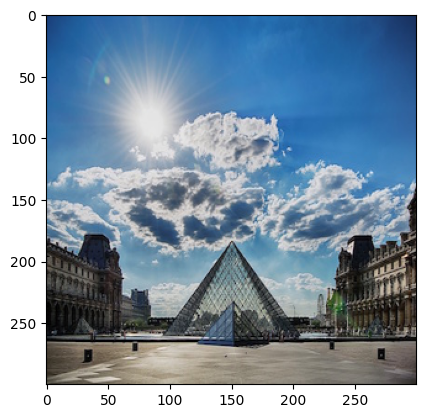

In [53]:
imshow(content_image[0])

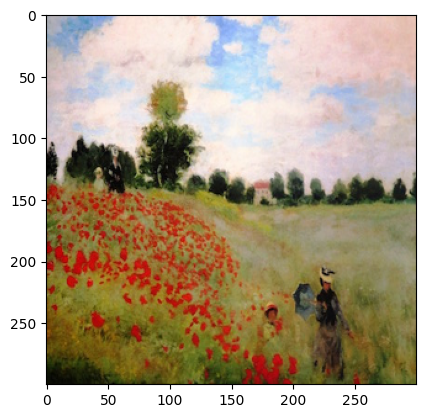

In [54]:
style_image = np.array(Image.open('./Images/monet.jpg').resize((img_size, img_size)))
style_image = tf.convert_to_tensor(np.reshape(style_image,((1,)+ style_image.shape)))
imshow(style_image[0])

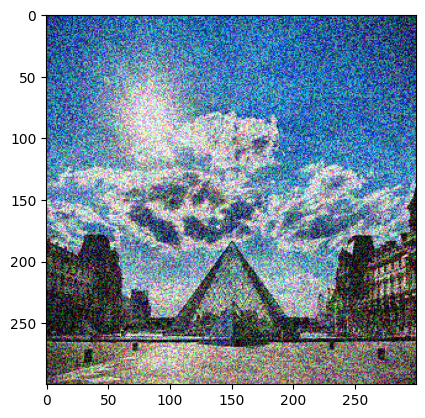

In [55]:
generated_image = tf.image.convert_image_dtype(content_image, dtype = tf.float32)
noise = tf.random.uniform(tf.shape(content_image),minval = -0.35,maxval = 0.35)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min= 0.0, clip_value_max =1.0)
imshow(generated_image[0])

In [56]:
generated_image.shape

TensorShape([1, 300, 300, 3])

In [57]:
def get_layer_outputs(vgg , all_layers):
    outputs = [vgg.get_layer(layer[0]).output for layer in all_layers]
    model = Model([vgg.input],outputs)
    return model

In [58]:
vgg_layer_outputs = get_layer_outputs(vgg , style_layers + content_layer)

In [59]:
def total_loss(content_loss,style_loss,alpha = 10, beta = 40):
    return alpha*content_loss + beta*style_loss

In [60]:
a_C = vgg_layer_outputs(tf.Variable(tf.image.convert_image_dtype(content_image,dtype=tf.float32)))
a_S = vgg_layer_outputs(tf.Variable(tf.image.convert_image_dtype(style_image,dtype=tf.float32)))

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_layer_outputs(generated_image)
        content_loss = compute_content_loss(a_C,a_G)
        style_loss = overall_style_loss(a_S,a_G)
        net_loss = total_loss(content_loss,style_loss,alpha = 10, beta = 40)

    grad = tape.gradient(net_loss,generated_image)
    optimizer.apply_gradients([(grad,generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image,clip_value_min=0.0,clip_value_max=1.0))

In [67]:
def tensor_to_image(img_tensor):
    img_tensor = img_tensor *255
    img = np.array(img_tensor, dtype=np.uint8)
    return Image.fromarray(img)

In [68]:
def train(generated_image):
    epochs = 5001
    for i in range(epochs):
        train_step(generated_image)
        if i % 200 == 0:
            print(f'epoch {i}')
            image = tensor_to_image(generated_image)
            imshow(image)

In [ ]:
train(generated_image)